In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

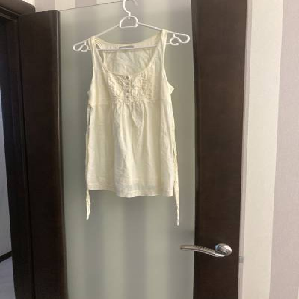

In [2]:
datapath = "./data/train/dress"
filename = "0a69db60-c052-4b9a-a90d-e53120d091d5.jpg"
fullpath = f"{datapath}/{filename}"
img = load_img(fullpath, target_size=(299, 299))
img

In [3]:
x = np.array(img)
x.shape

(299, 299, 3)

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [19]:
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


(1, 1000)

In [20]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n04550184', 'wardrobe', np.float32(0.39527887)),
  ('n04209239', 'shower_curtain', np.float32(0.16426839)),
  ('n03742115', 'medicine_chest', np.float32(0.06092096)),
  ('n04553703', 'washbasin', np.float32(0.028017683)),
  ('n02808440', 'bathtub', np.float32(0.017973801))]]

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=(150, 150),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './data/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [6]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10


/Users/majid/Projects/K8deployment/k8venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/96 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.2180 - loss: 2.2108

KeyboardInterrupt: 

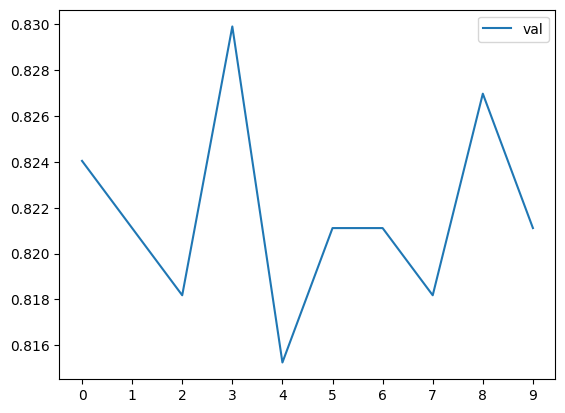

In [30]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [50]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [51]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [52]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
    scores[size] = history.history

    print()

10


ImportError: This requires the scipy module. You can install it via `pip install scipy`

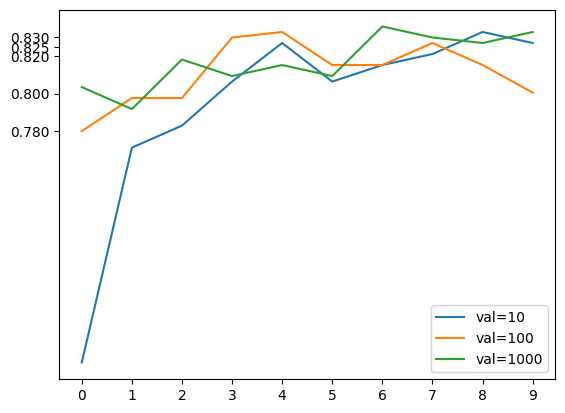

In [38]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

In [9]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [10]:
input_size = 299

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = train_gen.flow_from_directory(
    './data/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [11]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [13]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5487 - loss: 1.4365

/Users/majid/Projects/K8deployment/k8venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5501 - loss: 1.4323 - val_accuracy: 0.8123 - val_loss: 0.6044
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8066 - loss: 0.5806

96/96 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8067 - loss: 0.5803 - val_accuracy: 0.8475 - val_loss: 0.4339
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8565 - loss: 0.4381

96/96 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8565 - loss: 0.4381 - val_accuracy: 0.8651 - val_loss: 0.4328
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8682 - loss: 0.3969 - val_accuracy: 0.8475 - val_loss: 0.4151
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8703 - loss: 0.3745

96/96 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8704 - loss: 0.3743 - val_accuracy: 0.8768 - val_loss: 0.3803
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8914 - loss: 0.3369

96/96 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8914 - loss: 0.3368 - val_accuracy: 0.8856 - val_loss: 0.3779
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8973 - loss: 0.3049 - val_accuracy: 0.8592 - val_loss: 0.3779
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8944 - loss: 0.2746

96/96 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8944 - loss: 0.2746 - val_accuracy: 0.8886 - val_loss: 0.3605
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9158 - loss: 0.2472 - val_accuracy: 0.8798 - val_loss: 0.3682
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9265 - loss: 0.2429 - val_accuracy: 0.8798 - val_loss: 0.3435


In [15]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './data/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [17]:
model = keras.models.load_model('xception_v2_08_0.889.h5')
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8693 - loss: 0.3625


[0.2785474359989166, 0.897849440574646]

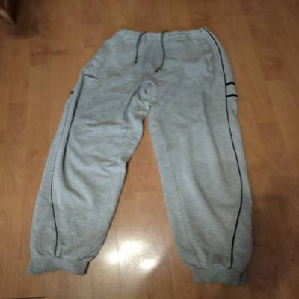

In [18]:
datapath = "./data/test/pants"
filename = "0dfec862-c49f-430b-a6ef-c7ceb187225e.jpg"
fullpath = f"{datapath}/{filename}"
img = load_img(fullpath, target_size=(299, 299))
img

In [19]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]
dict(zip(classes, pred[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


{'dress': np.float32(-2.0445218),
 'hat': np.float32(-3.855922),
 'longsleeve': np.float32(-1.9021839),
 'outwear': np.float32(-0.43989128),
 'pants': np.float32(8.728396),
 'shirt': np.float32(-0.1378815),
 'shoes': np.float32(-3.0256789),
 'shorts': np.float32(2.398514),
 'skirt': np.float32(-4.609029),
 't-shirt': np.float32(-4.4089427)}

## Convert model to tflite model

In [20]:
model = keras.models.load_model('xception_v2_08_0.889.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("clothes_classifier.tflite", "wb") as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/9p/9nbt0hzx4f71r06ht633_g4m0000gn/T/tmpl3mm9dq0/assets


INFO:tensorflow:Assets written to: /var/folders/9p/9nbt0hzx4f71r06ht633_g4m0000gn/T/tmpl3mm9dq0/assets


Saved artifact at '/var/folders/9p/9nbt0hzx4f71r06ht633_g4m0000gn/T/tmpl3mm9dq0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5882632448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882644080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882646192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882639312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882641600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882637200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882648128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882650944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882645136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882649184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5882643024: Tensor

W0000 00:00:1738971619.466955 3572922 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1738971619.467322 3572922 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-07 18:40:19.469888: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/9p/9nbt0hzx4f71r06ht633_g4m0000gn/T/tmpl3mm9dq0
2025-02-07 18:40:19.476005: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-07 18:40:19.476023: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/9p/9nbt0hzx4f71r06ht633_g4m0000gn/T/tmpl3mm9dq0
I0000 00:00:1738971619.549038 3572922 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-07 18:40:19.563122: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-07 18:40:20.109855: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [23]:
## read and preprocessing function
from PIL import Image
def read_image(path):
    with Image.open(path) as img:
        img = img.resize((299, 299), Image.NEAREST)
    return img

def preprocess_input(x):
    x = x / 127.5
    x -= 1.
    return x

In [25]:
datapath = "./data/test/pants"
filename = "0dfec862-c49f-430b-a6ef-c7ceb187225e.jpg"
fullpath = f"{datapath}/{filename}"
x = read_image(fullpath)
x = np.array([x], dtype='float32')
x = preprocess_input(x)
x.shape


(1, 299, 299, 3)

In [28]:
import tensorflow.lite as tflite
interpreter = tflite.Interpreter(model_path="./clothes_classifier.tflite")
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [29]:
interpreter.set_tensor(input_index, x)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
preds

array([[-2.044523  , -3.855922  , -1.9021837 , -0.4398911 ,  8.728395  ,
        -0.13787973, -3.0256784 ,  2.3985136 , -4.609027  , -4.408944  ]],
      dtype=float32)